In [1]:
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [71]:
def data_load(i):
    return pd.read_csv('dataset/dataset_%d.txt'%i, sep=',',header=None)

def csv_load(title):
    return pd.read_csv('%s.csv'%title, header = None)

In [3]:
def data_visualisation(data, colS, colE, label, title):
    df_activity = df[df[24] == label].values
    plt.plot(df_activity[:, colS:colE])
    plt.title(title)
    plt.show()
    
def visualise_all(data, title):
    plt.plot(data)
    plt.title(title)
    plt.show()

In [31]:
#returns a filtered dataset
def noise_removing(data, accORgyro, label): 
    b, a = signal.butter(4, 0.04, 'low', analog=False)
    df_activity = df[df[24] == label].values
    if accORgyro == 'acc':
        initial = 0
        stop = 3
    else:
        initial = 3
        stop = 6   
    for i in range(initial, stop):
        df_activity[:,i] = signal.lfilter(b, a, df_activity[:, i])
    return df_activity

def filter_set(data, i):
    activity_data = data[data[24] == i].values
    b, a = signal.butter(4, 0.04, 'low', analog=False)
    for j in range(24):
        activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
    return activity_data
    
#displays a filtered dataset
def show_filtered(data, start, end, accORgyro, label, title): 
    df = noise_removing(data, accORgyro, label)
    if accORgyro == 'acc':
        initial = 0
        stop = 3
    else:
        initial = 3
        stop = 6
    visualise_all(df[start:end,initial:stop], title)

In [117]:
def feature_extract(input_data):
    feature_data = []
    for i in range(3):
        feature_data.append(np.min(input_data[:, i]))
        feature_data.append(np.max(input_data[:, i]))
        feature_data.append(np.mean(input_data[:, i]))
        feature_data.append(np.average(input_data[:, i]))
    feature_data.append(input_data[0, -1])
    feature_data = np.array([feature_data])
    return feature_data
            

In [118]:
def data_prep(data, testORtrain, reduced_data):
    data_len = len(data)
    usage_len = math.floor(data_len * 0.8)
    training_number = usage_len // 1000 + 1
    if testORtrain == 'train':
        training_data = data[:usage_len, :]
        for s in range(training_number):
            if s < training_number - 1:
                sample_data = training_data[1000*s:1000*(s + 1), :]
            else:
                sample_data = training_data[1000*s:, :]
            training_features = feature_extract(sample_data)
            reduced_data = np.concatenate((reduced_data, training_features), axis=0)
        return reduced_data
    
    else:
        testing_number = (data_len - usage_len) // 1000 + 1
        testing_data = data[usage_len:, :]
        for s in range(testing_number):
            if s < training_number - 1:
                sample_data = testing_data[1000*s:1000*(s + 1), :]
            else:
                sample_data = testing_data[1000*s:, :]

            testing_features = feature_extract(sample_data)
            reduced_data = np.concatenate((reduced_data, testing_features), axis=0)
        return reduced_data

In [64]:
def feature_engineering():
    training = np.empty(shape=(0, 13))
    testing = np.empty(shape=(0, 13))
    # deal with each dataset file
    for i in range(19):
        df = data_load(i+1)
        print('deal with dataset ' + str(i + 1))
        for c in range(1, 14):
            activity_data = filter_set(df, c)
            
            training = data_prep(activity_data, 'train', training)
            testing = data_prep(activity_data, 'test', testing)

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)

In [123]:
def train_test_values():
    df_train = csv_load('training_data')
    df_test = csv_load('testing_data')
    
    Y_train = df_train[12].values
    # Labels should start from 0 in sklearn
    Y_train = Y_train - 1
    df_train = df_train.drop([12], axis=1)
    
    X_train = df_train.values
    Y_test = df_test[12].values
    Y_test = Y_test - 1
    df_test = df_test.drop([12], axis=1)
    X_test = df_test.values
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return [X_train, Y_train, X_test, Y_test]

def training_KNN(values):
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(values[0], values[1])
    return knn
    
def training_SVM(values):
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
    acc_scorer = make_scorer(accuracy_score)
    grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
    grid_obj  = grid_obj.fit(values[0], values[1])
    clf = grid_obj.best_estimator_
    clf.fit(values[0], values[1])
    return clf

In [ ]:
def evaluate_KNN(knn, values):
    y_pred = knn.predict(values[2])
    evalution(values, y_pred)

def evaluate_SVM(svm, values):
    y_pred = svm.predict(values[2])
    evaluation(values, y_pred)
    
def evalution(values, y_pred):
    print('Accuracy: ', accuracy_score(values[3], y_pred))
    print(confusion_matrix(values[3], y_pred))

In [129]:
def model_training_and_evaluation():
    values = train_test_values()
    knn = training_KNN(values)
    evaluate_KNN(knn, values)
    svm = training_SVM(values)
    evaluate_SVM(svm, values)
    

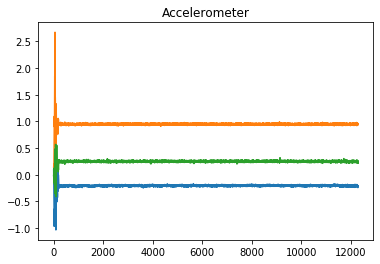

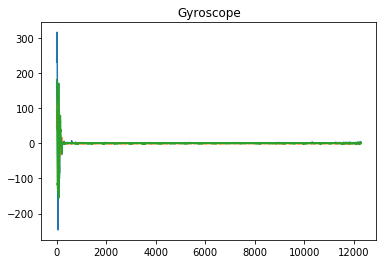

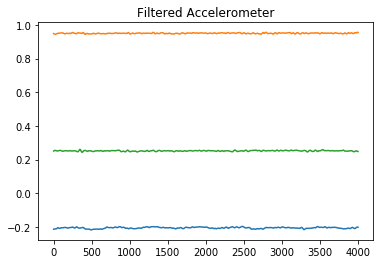

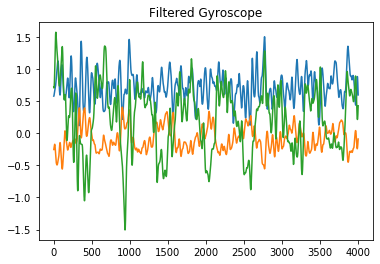

In [7]:
df = data_load(1)
data_visualisation(df,0,3,1, 'Accelerometer')
data_visualisation(df,3,6,1, 'Gyroscope')
show_filtered(df, 1000, 5000, 'acc', 1, 'Filtered Accelerometer')
show_filtered(df, 1000, 5000, 'gyro', 1, 'Filtered Gyroscope')

In [119]:
feature_engineering()


deal with dataset 1
deal with dataset 2
deal with dataset 3
deal with dataset 4
deal with dataset 5
deal with dataset 6
deal with dataset 7
deal with dataset 8
deal with dataset 9
deal with dataset 10
deal with dataset 11
deal with dataset 12
deal with dataset 13
deal with dataset 14
deal with dataset 15
deal with dataset 16
deal with dataset 17
deal with dataset 18
deal with dataset 19


In [ ]:
model_training_and_evaluation()

Accuracy:  0.7476007677543186
[[ 45   2   0   0   0   1   0   0   0   0   6   3   0]
 [  2  55   0   0   0   0   0   0   0   0   0   0   0]
 [  0   3  48   1   2   0   1   0   0   0   1   1   0]
 [  3   0   1  83   5   5   2   0   0   0   0   0   0]
 [  0   0   1   8  37   6   1   3   0   0   1   0   0]
 [  0   1   1  16  26  29   5   2   2   0   1   2   0]
 [  0   0   4   4   1   9 197   2   2   0   0   0   0]
 [  0   0   1   0   1   2  19  16   0   0   0   0   0]
 [  0   0   0   1   1   0  11   2  22   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0  96   0   0   0]
 [  0   0   1   3   2   5   3   0   1   0  62  23   0]
 [  0   0   0   2   0   0   0   0   0   0  44  54   0]
 [  0   0   0   0   0   0   2   0   0   1   0   0  35]]
